# Import Modules

In [1]:
import json

import pandas as pd
import numpy as np
import torch

import utils

/home/higuchi-lab/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Set Vegetable

In [2]:
vegetable = utils.VEGETABLES[9]
training_size = 4000

json_open = open('./free_params.json', 'r')
params = json.load(json_open)
param = params[vegetable]

print(f"vegetable: {vegetable}")
print(f"free params: {param}")
print(f"training size: {training_size}")

vegetable: トマト
free params: {'T': 10, 'batch_size': 16, 'num_epochs': 150, 'learning_rate': 0.001, 'weight_decay': 0.001, 'eps': 1e-08, 'hidden_size': 500, 'dropout_ratio': 0.5, 'is_attention': 1, 'num_ensamble': 5, 'seed': 1}
training size: 4000


# Load Data

In [3]:
train_test = pd.read_csv("./data/mapped_train_test.csv")
train_test["date"] = pd.to_datetime(train_test["date"], format="%Y-%m-%d")
weather = pd.read_csv("./data/sorted_mapped_adjusted_weather.csv")
train_test = pd.concat([train_test, weather], axis=1)

train_test["year"] = train_test.date.dt.year
years = pd.get_dummies(train_test["year"])
train_test = train_test.drop(columns="year")
train_test = pd.concat([train_test, years], axis=1)

train_test["month"] = train_test.date.dt.month
months = pd.get_dummies(train_test["month"])
train_test = train_test.drop(columns="month")
train_test = pd.concat([train_test, months], axis=1)

areas = pd.get_dummies(train_test["area"])
train_test = train_test.drop(columns="area")
train_test = pd.concat([train_test, areas], axis=1)

train = train_test[:pd.read_csv("./data/train.csv").shape[0]]

target_values = utils.get_target_values(train, vegetable)
changed_col = [1, 0] + [i for i in np.arange(2, target_values.shape[1])]
target_values = target_values[:, changed_col]
train_loader, test_y, train, test, ss = utils.preprocess_data(target_values, train_size=training_size,
                                                              T=param["T"], batch_size=param["batch_size"])

In [5]:
future = test.shape[0]
torch.manual_seed(param["seed"])
torch.cuda.manual_seed_all(param["seed"])

# Training

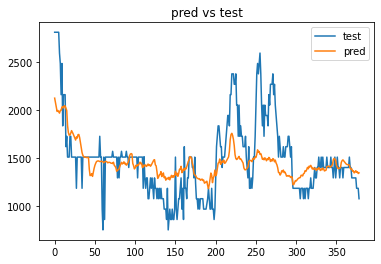

In [6]:
pred_y = utils.pipeline_rnn(train_loader, train, test, param, future=future)

pred_y = pred_y.cpu().detach().numpy()
pred = np.concatenate([pred_y.reshape(-1, 1), test[:, 1:]], axis=1)

utils.plot_prediction(pred, test, ss)